# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities.

Modified from the previous strategy, only process the classification results batch by batch.

In [11]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

## Disable truncation globally
pl.Config.set_tbl_rows(20)  # Show all rows
pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

%matplotlib inline

# ctrls = TC + NC + PC
# import json
# formatted_list = json.dumps(cPC)
# print(formatted_list)

## Visualize platemaps

In [3]:
def plot_platemap(df, plate_name):
    # Create a 16x24 grid for the 384-well plate
    rows = list('ABCDEFGHIJKLMNOP')
    cols = [f'{i:02d}' for i in range(1, 25)]
    # Initialize the plate grid with empty values
    plate_grid = pl.DataFrame({col: ['' for _ in rows] for col in cols}, schema={col: pl.Utf8 for col in cols})
    
    # Add a row index to the plate grid
    plate_grid = plate_grid.with_row_index('row')
    # Unpivot the plate grid to long format
    plate_grid = plate_grid.unpivot(index='row', on=cols, variable_name='col', value_name='value')
    
    # Add row and column labels
    plate_grid = plate_grid.with_columns(
        pl.col('row').map_elements(lambda x: rows[x], return_dtype=pl.Utf8).alias('row_label'),  # Map row index to row label (A-P)
        pl.col('col').alias('col_label')  # Use the column name directly as the column label
    )
    # Merge with the input data
    df = df.with_columns(
        pl.col('well_position').str.head(1).alias('row_label'),
        pl.col('well_position').str.slice(1).alias('col_label')
    )
    # Join the input data with the plate grid
    plate_grid = plate_grid.join(df, on=['row_label', 'col_label'], how='left')
    # print(plate_grid.select(pl.col("control_type")).unique())
    # Fill missing values in the gene column
    plate_grid = plate_grid.with_columns(
        pl.col('symbol').fill_null(''),
        pl.col('gene_allele').fill_null(''),
        pl.col('gene_allele').str.replace("_", '\n')
          .alias('label')
    )
    # Reshape the grid for plotting
    # heatmap_data = plate_grid.pivot(index='row_label', columns='col_label', values='color').fill_null('white')
    heatmap_data = plate_grid.pivot(index='row_label', on='col_label', values='label').fill_null('')
    # print(heatmap_data)
    # Assign colors based on conditions
    heatmap_colors = plate_grid.pivot(index='row_label', on='col_label', values='control_type').fill_null('')
    # print(heatmap_colors)

    # Convert to numpy arrays for plotting
    heatmap_labels = heatmap_data[:, 1:].to_numpy()
    heatmap_colors = heatmap_colors[:, 1:].to_numpy()
    # print(heatmap_colors)
    
    # Create a color map for the heatmap
    color_map = {
        '_TC_': 'slategrey', # Grey for controls
        'TC': 'slategrey', # Grey for controls
        'NC': 'gainsboro', 
        'PC': 'plum',
        'cPC': 'pink',
        'cNC': 'lightgrey',
        'allele': 'salmon',  # Tomato for disease
        'disease_wt': 'lightskyblue',  # Skyblue for reference
        '': 'white'  # White for missing wells
    }
    
    # Map the colors to the grid
    heatmap_colors = np.vectorize(color_map.get)(heatmap_colors)
    
    # Plot the heatmap
    plt.figure(figsize=(35, 13.5))
    sns.heatmap(
        np.zeros_like(heatmap_labels, dtype=int),  # Dummy data for heatmap
        annot=heatmap_labels,
        fmt='',
        # cmap='viridis',  # Dummy colormap (not used for coloring)
        cbar=False,
        linewidths=1,
        linecolor='black',
        square=True,
        annot_kws={'size': 8.5, 'color': 'black'}
    )
    
    # Apply colors manually
    for i in range(heatmap_colors.shape[0]):
        for j in range(heatmap_colors.shape[1]):
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=heatmap_colors[i, j], fill=True))
    
    # Customize the plot
    plt.title(f"384-Well Plate Map: {plate_name}", fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Rows', fontsize=12)
    plt.xticks(ticks=np.arange(1,25)-.5, labels=cols, rotation=0)
    plt.yticks(ticks=np.arange(16) + 0.5, labels=rows, rotation=0)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plate_grid

In [4]:
def check_batch_pms(batch_dir):
    # batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"
    platemap_set = sorted(set([platemap_id.split('_T')[0] for platemap_id in os.listdir(batch_dir)]))
    print("Platemaps available for batch:", platemap_set)
    for platemap_id in platemap_set:
        pm_ref_df = pl.read_csv(Path(batch_dir) / Path(platemap_id+"_T1.txt"), separator='\t', has_header=True)
        columns_to_include = pm_ref_df.columns[1:]
        for pm_file in [pm for pm in os.listdir(batch_dir) if platemap_id in pm and "T1" not in pm]:
            pm_df = pl.read_csv(Path(batch_dir) / Path(pm_file), separator='\t', has_header=True)
            df1_selected = pm_ref_df.select(columns_to_include)
            df2_selected = pm_df.select(columns_to_include)
            assert df1_selected.equals(df2_selected)
            print(f"{pm_file} is equal to ref. {platemap_id}_T1.txt")

In [5]:
plate_map_dir = Path("../inputs/metadata/platemaps") / Path("2024_01_23_Batch_7/platemap")
print(os.listdir(plate_map_dir))

total_allele_count = 0
for plate_map_id in os.listdir(plate_map_dir):
    # plate_map_id = "B7A1R1_P1.txt"
    if "B7A2R1" in plate_map_id or "B8A2R2_P1" in plate_map_id:
        continue

    meta_dat_b134_corrected = pl.read_csv(plate_map_dir /Path(plate_map_id), separator='\t', has_header=True)
    meta_dat_b134_corrected

    # Plot first platemap
    plate_map = meta_dat_b134_corrected.filter(
                    ~pl.all_horizontal(pl.all().is_null())
                ).filter(~pl.col("gene_allele").is_null())
    # plate_grid = plot_platemap(plate_map, plate_map_id)

    # plate_grid.select(pl.col("control_type")).unique()
    # print(plate_grid.filter(pl.col("well_position")=="H07"))
    print(plate_map_id, "tested alleles:", plate_map.filter(pl.col("control_type")=="allele").unique().shape[0])
    total_allele_count += plate_map.filter(pl.col("node_type")=="allele").select(pl.col("gene_allele")).unique().shape[0]

print("Total alleles tested:", total_allele_count)

['B7A2R1_P1.txt', 'B7A1R1_P1.txt', 'B7A1R1_P4.txt', 'B7A1R1_P3.txt', 'B7A1R1_P2.txt']
B7A1R1_P1.txt tested alleles: 253
B7A1R1_P4.txt tested alleles: 195
B7A1R1_P3.txt tested alleles: 267
B7A1R1_P2.txt tested alleles: 279
Total alleles tested: 969


In [6]:
plate_map_dir = Path("../inputs/metadata/platemaps") / Path("2024_02_06_Batch_8/platemap")
print(os.listdir(plate_map_dir))

total_allele_count = 0
for plate_map_id in os.listdir(plate_map_dir):
    # plate_map_id = "B7A1R1_P1.txt"
    if "B7A2R1" in plate_map_id or "B8A2R2_P1" in plate_map_id:
        continue
    meta_dat_b134_corrected = pl.read_csv(plate_map_dir /Path(plate_map_id), separator='\t', has_header=True)
    # Plot first platemap
    plate_map = meta_dat_b134_corrected.filter(
                    ~pl.all_horizontal(pl.all().is_null())
                ).filter(~pl.col("gene_allele").is_null())
    
    total_allele_count += plate_map.filter(pl.col("node_type")=="allele").select(pl.col("gene_allele")).unique().shape[0]

print("Total alleles tested:", total_allele_count)

['B8A1R2_P1.txt', 'B8A1R2_P3.txt', 'B8A1R2_P4.txt', 'B8A1R2_P2.txt', 'B8A2R2_P1.txt']
Total alleles tested: 969


## Compute metrics

In [27]:
# # Define a function to compute metrics for each group
# def compute_aubprc(auprc, prior):
#     return (auprc * (1 - prior)) / ((auprc * (1 - prior)) + ((1 - auprc) * prior))


# def compute_metrics(group):
#     y_true = group["Label"].to_numpy()
#     y_prob = group["Prediction"].to_numpy()
#     y_pred = (y_prob > 0.5).astype(int)
#     prior = sum(y_true == 1) / len(y_true)

#     class_ID = group["Classifier_ID"].unique()[0]

#     # Compute AUROC
#     auroc = roc_auc_score(y_true, y_prob)

#     # Compute AUPRC
#     auprc = average_precision_score(y_true, y_prob)
#     aubprc = compute_aubprc(auprc, prior)

#     # Compute macro-averaged F1 score
#     macro_f1 = f1_score(y_true, y_pred, average="macro")

#     # Compute sensitivity and specificity
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     sensitivity = tp / (tp + fn)
#     specificity = tn / (tn + fp)

#     # Compute balanced accuracy
#     balanced_acc = balanced_accuracy_score(y_true, y_pred)

#     return {
#         "AUROC": auroc,
#         "AUPRC": auprc,
#         "AUBPRC": aubprc,
#         "Macro_F1": macro_f1,
#         "Sensitivity": sensitivity,
#         "Specificity": specificity,
#         "Balanced_Accuracy": balanced_acc,
#         "Classifier_ID": class_ID,
#     }


# def calculate_class_metrics(classifier_info: str, predictions: str, metrics_file: str):
#     batch_id = [subdir for subdir in classifier_info.split("/") if "Batch" in subdir][0]
#     batch_id = f"B{batch_id.split('Batch_')[-1]}"

#     # read in classifier info
#     class_info = pl.read_csv(classifier_info)
#     class_info = class_info.with_columns(
#         (pl.col("trainsize_1") / (pl.col("trainsize_0") + pl.col("trainsize_1"))).alias(
#             "train_prob_1"
#         ),
#         (pl.col("testsize_1") / (pl.col("testsize_0") + pl.col("testsize_1"))).alias(
#             "test_prob_1"
#         ),
#     )

#     # read in predictions
#     preds = pl.scan_parquet(predictions)
#     preds = preds.with_columns(pl.lit(batch_id).alias("Batch")).collect()
#     preds = preds.with_columns(
#         pl.concat_str(
#             [pl.col("Classifier_ID"), pl.col("Metadata_Protein"), pl.col("Batch")],
#             separator="_",
#         ).alias("Full_Classifier_ID")
#     )

#     # Initialize an empty list to store the results
#     results = []
#     classIDs = preds.select("Full_Classifier_ID").to_series().unique().to_list()

#     # Group by Classifier_ID and compute metrics for each group
#     for id in tqdm(classIDs):
#         metrics = compute_metrics(preds.filter(pl.col("Full_Classifier_ID") == id))
#         metrics["Full_Classifier_ID"] = id
#         results.append(metrics)

#     # Convert the results to a Polars DataFrame
#     metrics_df = pl.DataFrame(results)

#     # Add classifier info and save
#     metrics_df = metrics_df.join(class_info, on="Classifier_ID")
#     metrics_df = metrics_df.with_columns(
#         (
#             pl.max_horizontal(["trainsize_0", "trainsize_1"])
#             / pl.min_horizontal(["trainsize_0", "trainsize_1"])
#         ).alias("Training_imbalance"),
#         (
#             pl.max_horizontal(["testsize_0", "testsize_1"])
#             / pl.min_horizontal(["testsize_0", "testsize_1"])
#         ).alias("Testing_imbalance"),
#     )
#     metrics_df.write_csv(metrics_file)

#     return metrics_df

# # metrics_df = calculate_class_metrics(feat_info="../outputs/results/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/feat_importance.csv",
# #                                      classifier_info="../outputs/results/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/classifier_info.csv",
# #                                      predictions="../outputs/results/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/predictions.parquet",
# #                                      metrics_file="../outputs/analyses/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/metrics.csv")

In [53]:
trn_imbal_thres = 3
min_class_num = 2

metrics_files = [
    "../outputs/analyses/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/metrics.csv",
    "../outputs/analyses/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect/metrics.csv"
]

metric_df_dict = {}

for metric_file in metrics_files:
    metrics_df = pl.read_csv(metric_file)

    batch_id = [subdir for subdir in metric_file.split("/") if "Batch" in subdir][0]
    batch_id = f"B{batch_id.split('Batch_')[-1]}"

    # print(metrics_df)
    metrics_df = metrics_df.filter((~pl.col("Plate").str.contains("B7A2R1"))&(~pl.col("Plate").str.contains("B8A2R2")))

    metrics_df = metrics_df.with_columns(
        pl.when(pl.col("Metadata_Control"))
        .then(pl.lit("1_Ctrl"))
        .otherwise(pl.lit("2_VAR-WT"))
        .alias("Node_Type"),
        pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
        .then(pl.lit("localization"))
        .otherwise(pl.lit("morphology"))
        .alias("Classifier_type"),
        pl.format(
            "A{}P{}",  # 组合格式
            pl.col("Plate").str.extract(r'A(\d+)', 1),  # 提取A后的数字
            pl.col("Plate").str.extract(r'_P(\d+)T', 1)  # 提取P后的数字（排除T后的部分）
        ).alias("Allele_set"),
        pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
    )

    # Filter based on class imbalance
    metrics_ctrl = (
        metrics_df.filter(
            (pl.col("Training_imbalance") < thresh) & (pl.col("Metadata_Control"))
        )
        .select(["Classifier_type", "Batch", "AUROC"])
        .group_by(["Classifier_type", "Batch"])
        .agg([
            pl.col("AUROC").quantile(0.99).alias("AUROC_thresh"),
            pl.col("AUROC").mean().alias("AUROC_mean"),
            pl.col("AUROC").std().alias("AUROC_std")
        ])
    )
    # print(metrics_ctrl)

    metric_df_dict[f"{batch_id}_met"] = metrics_df

    # Merge with metrics_df and decide whether it passed the threshold
    metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
    # print(metrics_df_thres.head())

    metrics_df_thres = metrics_df_thres.with_columns(
        ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
    )

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("Total number of unique classifiers:", classifier_count.shape[0])
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (pl.col("Training_imbalance") < trn_imbal_thres)
            & (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("After filtering out classifiers with training imbalance > 3:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    classifier_count = classifier_count.filter(
        (pl.col(batch_id) >= min_class_num)
    )
    print("After filtering out alleles with available number of classifiers < 2:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))

    # filter based on this
    keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
    metrics_df_thres = metrics_df_thres.filter(
        ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
    )

    # Filter by imbalance and calculate mean AUROC for each batch
    metrics_wtvar = (
        (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < trn_imbal_thres) & (~pl.col("Metadata_Control"))
            )
        )
        .select([
            "AUROC",
            "AUROC_zscore",
            "Classifier_type",
            "Batch",
            "AUROC_thresh",
            "allele_0",
            "trainsize_0",
            "testsize_0",
            "trainsize_1",
            "testsize_1",
            "Allele_set",
            "Training_imbalance",
        ])
        .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
        .agg([
            pl.all()
            .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
            .mean()
            .name.suffix("_mean")
        ])
    )

    metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres

    metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

    print(metrics_wtvar)

Total number of unique classifiers: 643
Total number of unique variant alleles: 643
Total number of unique WT genes: 123
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (603, 4)
Total number of unique variant alleles: 603
Total number of unique WT genes: 117
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (590, 4)
Total number of unique variant alleles: 590
Total number of unique WT genes: 114
shape: (1_180, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Classi ┆ allele ┆ Allele ┆ Batch ┆ AUROC ┆ AUROC ┆ AUROC ┆ train ┆ tests ┆ train ┆ tests ┆ Train │
│ fier_t ┆ _0     ┆ _set   ┆ ---   ┆ _thre ┆ _mean ┆ _zsco ┆ size_ ┆ ize_0 ┆ size_ ┆ ize_1 ┆ ing_i │
│ ype    ┆ ---    ┆ ---    ┆ str   ┆ sh    ┆ ---   ┆ re_me ┆ 0_mea ┆ _mean ┆ 1_mea ┆ _mean ┆ mbala │
│ ---    ┆ str    ┆ str    ┆       ┆ ---   ┆ f64   ┆ an    ┆ n     ┆ --- 

In [66]:
metric_df_dict[f"B7_met"].filter(pl.col("allele_0")=="AGXT_Ile279Thr")

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str
0.997522,0.999448,0.997991,0.92841,0.93318,1.0,0.96659,"""2024_01_17_B7A1R1_P1T4_O07_E07""","""2024_01_17_B7A1R1_P1T4_O07_E07…","""2024_01_17_B7A1R1_P1T4""",26,119,"""O07""","""AGXT_Ile279Thr""",1687,434,"""E07""","""AGXT""",false,0.984822,0.78481,64.884615,3.647059,"""2_VAR-WT""","""localization""","""A1P1""","""B7"""
0.995721,0.998971,0.996256,0.884923,0.997696,0.689076,0.843386,"""2024_01_17_B7A1R1_P1T4_O07_E07""","""2024_01_17_B7A1R1_P1T4_O07_E07…","""2024_01_17_B7A1R1_P1T4""",26,119,"""O07""","""AGXT_Ile279Thr""",1687,434,"""E07""","""AGXT""",false,0.984822,0.78481,64.884615,3.647059,"""2_VAR-WT""","""morphology""","""A1P1""","""B7"""
0.963839,0.995968,0.935471,0.649714,1.0,0.192308,0.596154,"""2024_01_17_B7A1R1_P1T1_O07_E07""","""2024_01_17_B7A1R1_P1T1_O07_E07…","""2024_01_17_B7A1R1_P1T1""",119,26,"""O07""","""AGXT_Ile279Thr""",1678,443,"""E07""","""AGXT""",false,0.933779,0.944563,14.10084,17.038462,"""2_VAR-WT""","""morphology""","""A1P1""","""B7"""
0.994704,0.999681,0.994589,0.676462,1.0,0.230769,0.615385,"""2024_01_17_B7A1R1_P1T1_O07_E07""","""2024_01_17_B7A1R1_P1T1_O07_E07…","""2024_01_17_B7A1R1_P1T1""",119,26,"""O07""","""AGXT_Ile279Thr""",1678,443,"""E07""","""AGXT""",false,0.933779,0.944563,14.10084,17.038462,"""2_VAR-WT""","""localization""","""A1P1""","""B7"""


In [ ]:
wtvar_summary = pl.DataFrame()

for met, df in metric_df_dict.items():
    if "allele" in met:
        wtvar_summary = pl.concat([wtvar_summary, df])
        wtvar_summary

In [61]:
wtvar_summary.filter(pl.col("allele_0")=="GCK_Ala387Glu")

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh,AUROC_mean,AUROC_zscore_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""localization""","""GCK_Ala387Glu""","""A1P2""","""B7""",0.71418,0.703988,2.322567,418.5,139.5,261.0,87.0,1.600014
"""morphology""","""GCK_Ala387Glu""","""A1P2""","""B7""",0.997315,0.456115,-0.493661,418.5,139.5,261.0,87.0,1.600014


In [68]:
# # Alleles must be mislocalized in both batches
# local_wtvar = wtvar_summary.with_columns(
#     pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
#     .then(1)
#     .otherwise(0)
#     .alias("mislocalized")
# ).unique()

# misloc_binary = (
#     wtvar_summary.pivot(
#         index=["allele_0", "Allele_set"],
#         on="Batch",
#         values="mislocalized",
#     )
#     .with_columns(
#         ((pl.col("batch13") == 1) & (pl.col("batch14") == 1)).alias(
#             "mislocalized_both_batches"
#         )
#     )
#     .rename({"batch13": "mislocalized_batch13", "batch14": "mislocalized_batch14"})
# )

auroc_zscore = wtvar_summary.pivot(
    index=["allele_0","Allele_set","Classifier_type"],
    on="Batch",
    values="AUROC_zscore_mean",
).rename({"B7": "auroc_zscore_b7", "B8": "auroc_zscore_b8"})

# misloc_summary = misloc_binary.join(misloc_auroc, on="allele_0")
display(auroc_zscore)

auroc_zscore.write_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/sm_xgb_classifier_metrics/auroc_zscore_b7-8.csv")

allele_0,Allele_set,Classifier_type,auroc_zscore_b7,auroc_zscore_b8
str,str,str,f64,f64
"""SFTPB_Ala280Thr""","""A1P3""","""localization""",0.083813,0.141365
"""AGXT_Gly41Glu""","""A1P1""","""morphology""",0.563317,0.512268
"""TTPA_His101Gln""","""A1P4""","""morphology""",1.471469,0.386747
"""HPRT1_Asp80Val""","""A1P2""","""morphology""",0.752171,0.576988
"""NCF2_Asp93Glu""","""A1P3""","""morphology""",0.521047,0.378231
"""HBD_Arg105Ser""","""A1P2""","""localization""",0.029841,-0.26251
"""COMP_Thr585Met""","""A1P1""","""localization""",3.014747,0.770819
"""GCK_Ala387Glu""","""A1P2""","""localization""",2.322567,null
"""AGXT_Arg289His""","""A1P1""","""localization""",5.689074,null


## Plotting Metrics

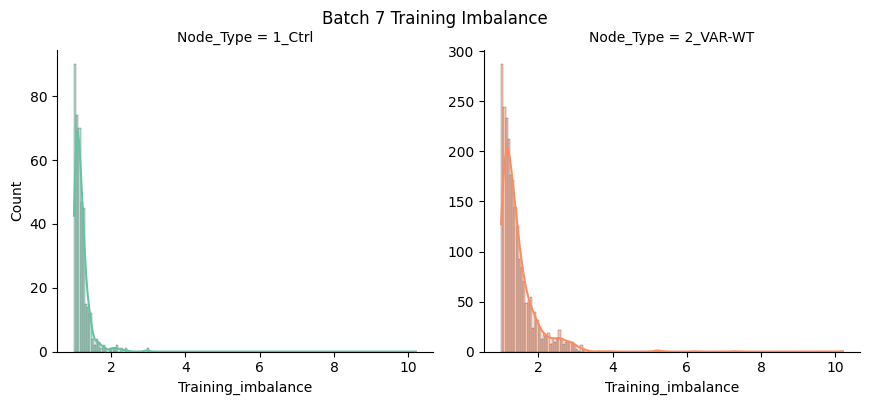

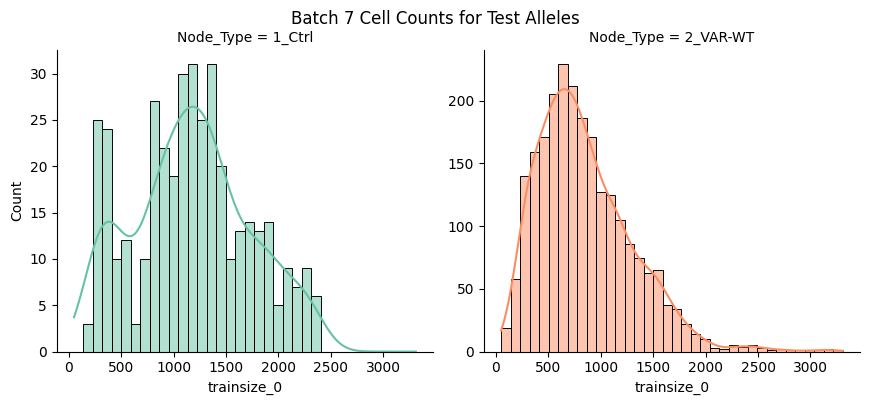

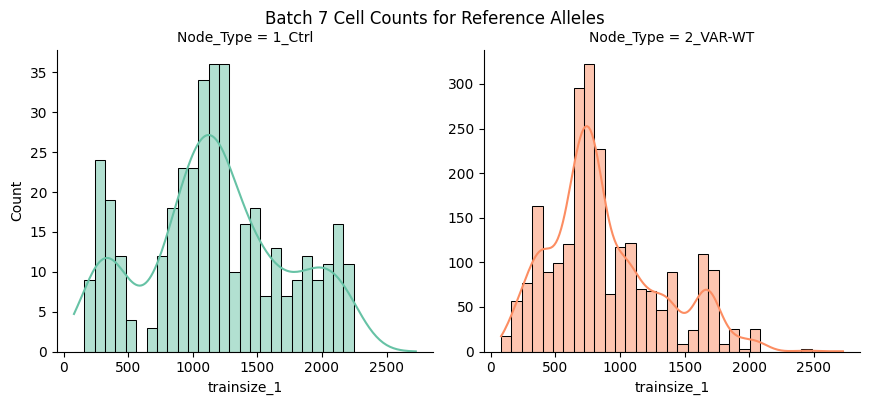

In [45]:
# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="Training_imbalance", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 7 Training Imbalance", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="trainsize_0", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 7 Cell Counts for Test Alleles", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="trainsize_1", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 7 Cell Counts for Reference Alleles", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

0.7141798876473857
0.8613916447924544


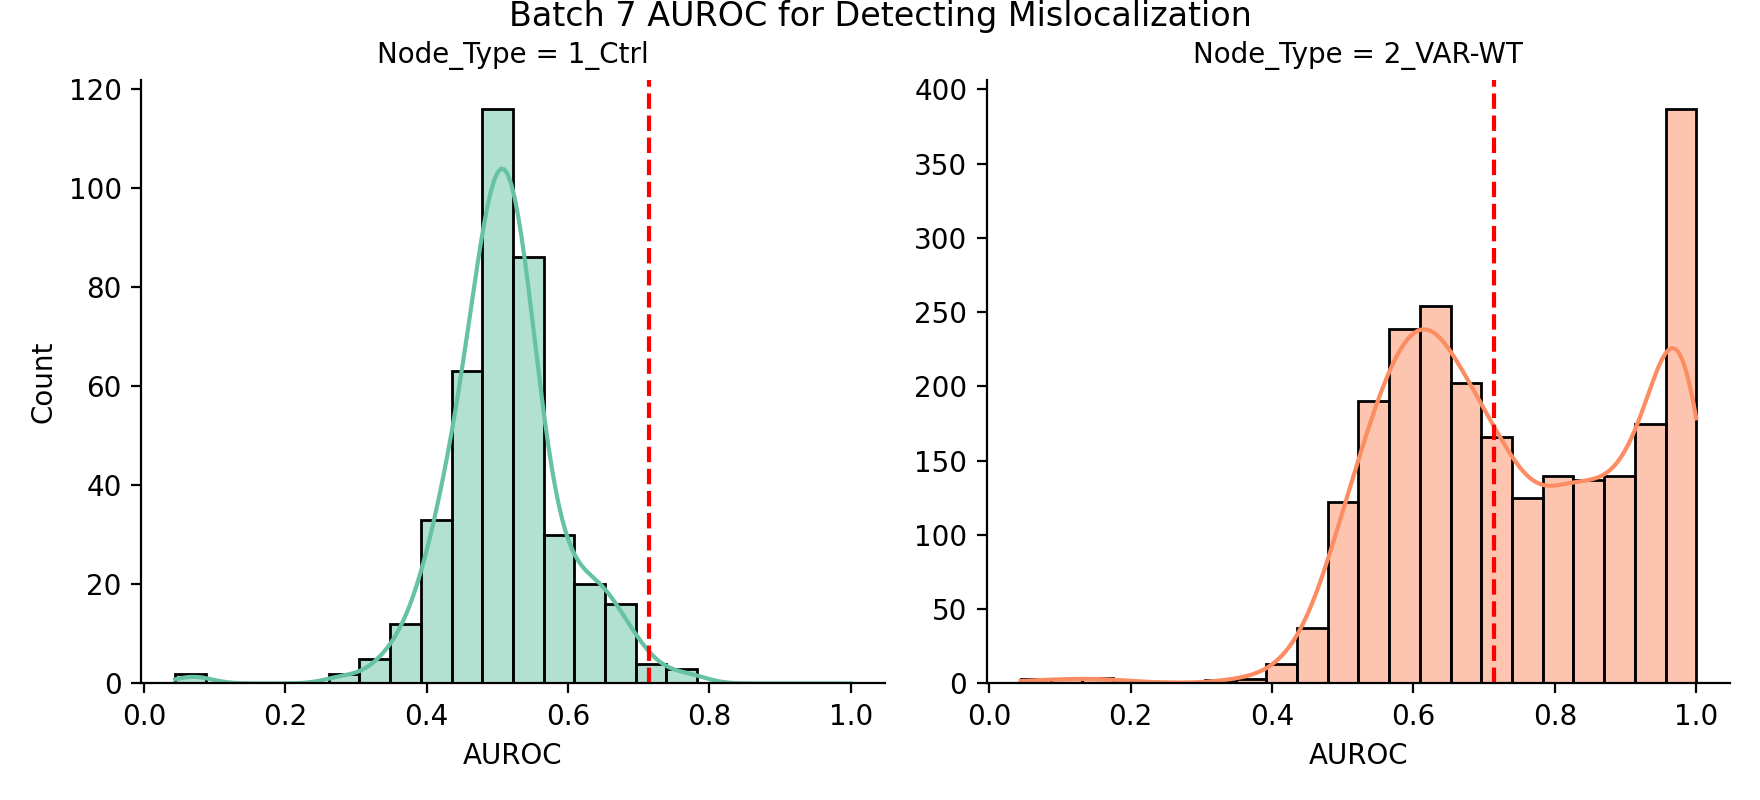

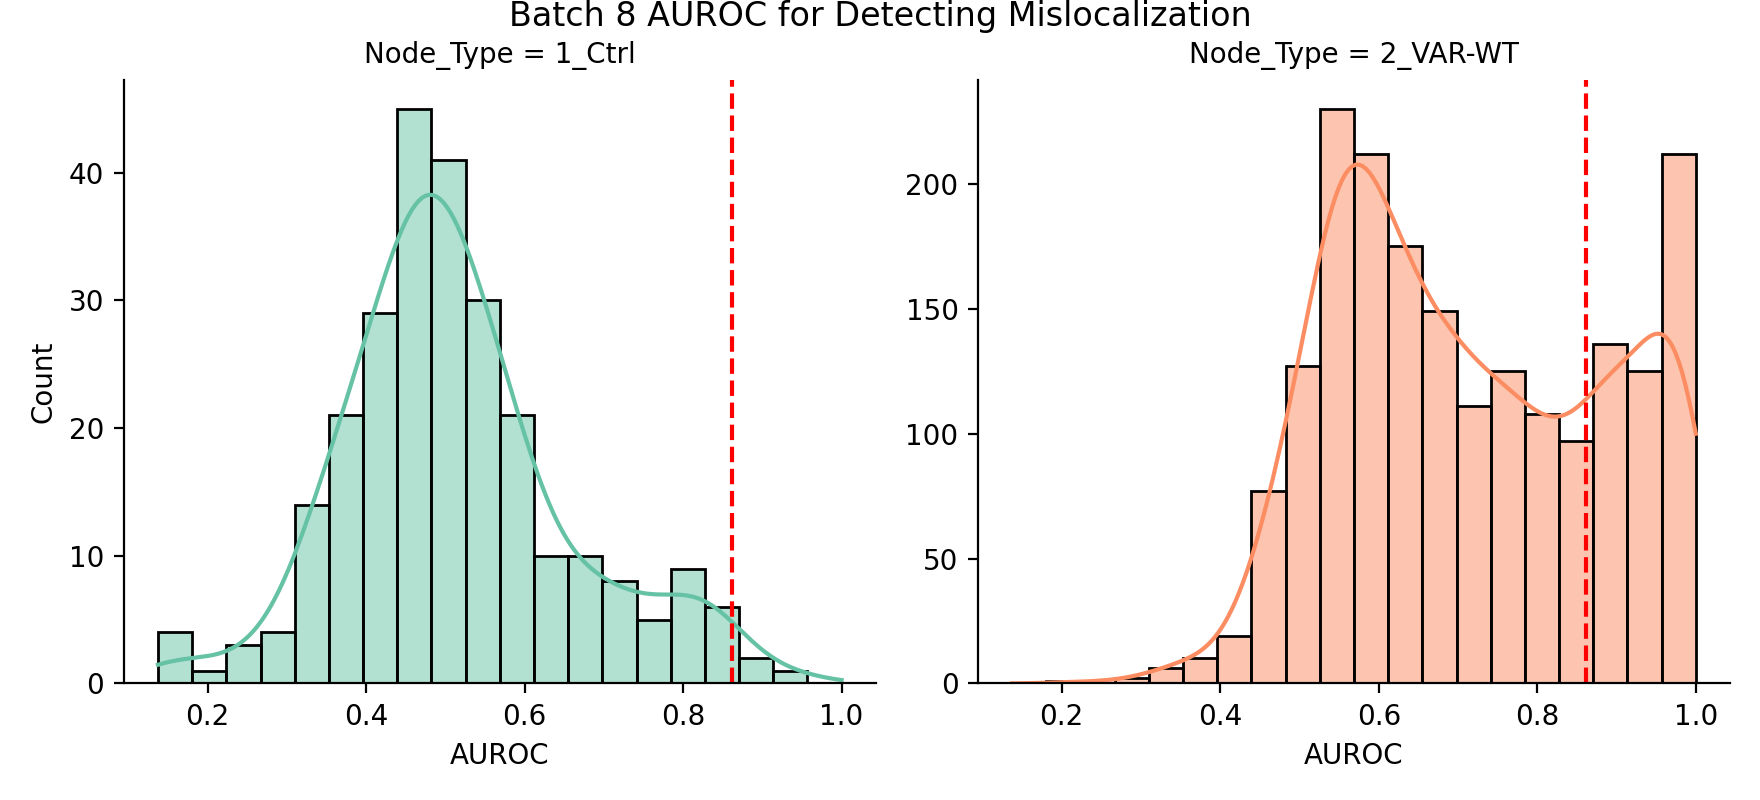

In [ ]:
perc_99 = metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "localization").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "localization"), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
# plt.show()

g.fig.suptitle("Batch 7 AUROC for Detecting Mislocalization", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

perc_99 = metric_df_dict["B8_met_thres"].filter(pl.col("Classifier_type") == "localization").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B8_met_thres"].filter(pl.col("Classifier_type") == "localization"), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')

g.fig.suptitle("Batch 8 AUROC for Detecting Mislocalization", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

0.9973146490524106
0.9980701459976504


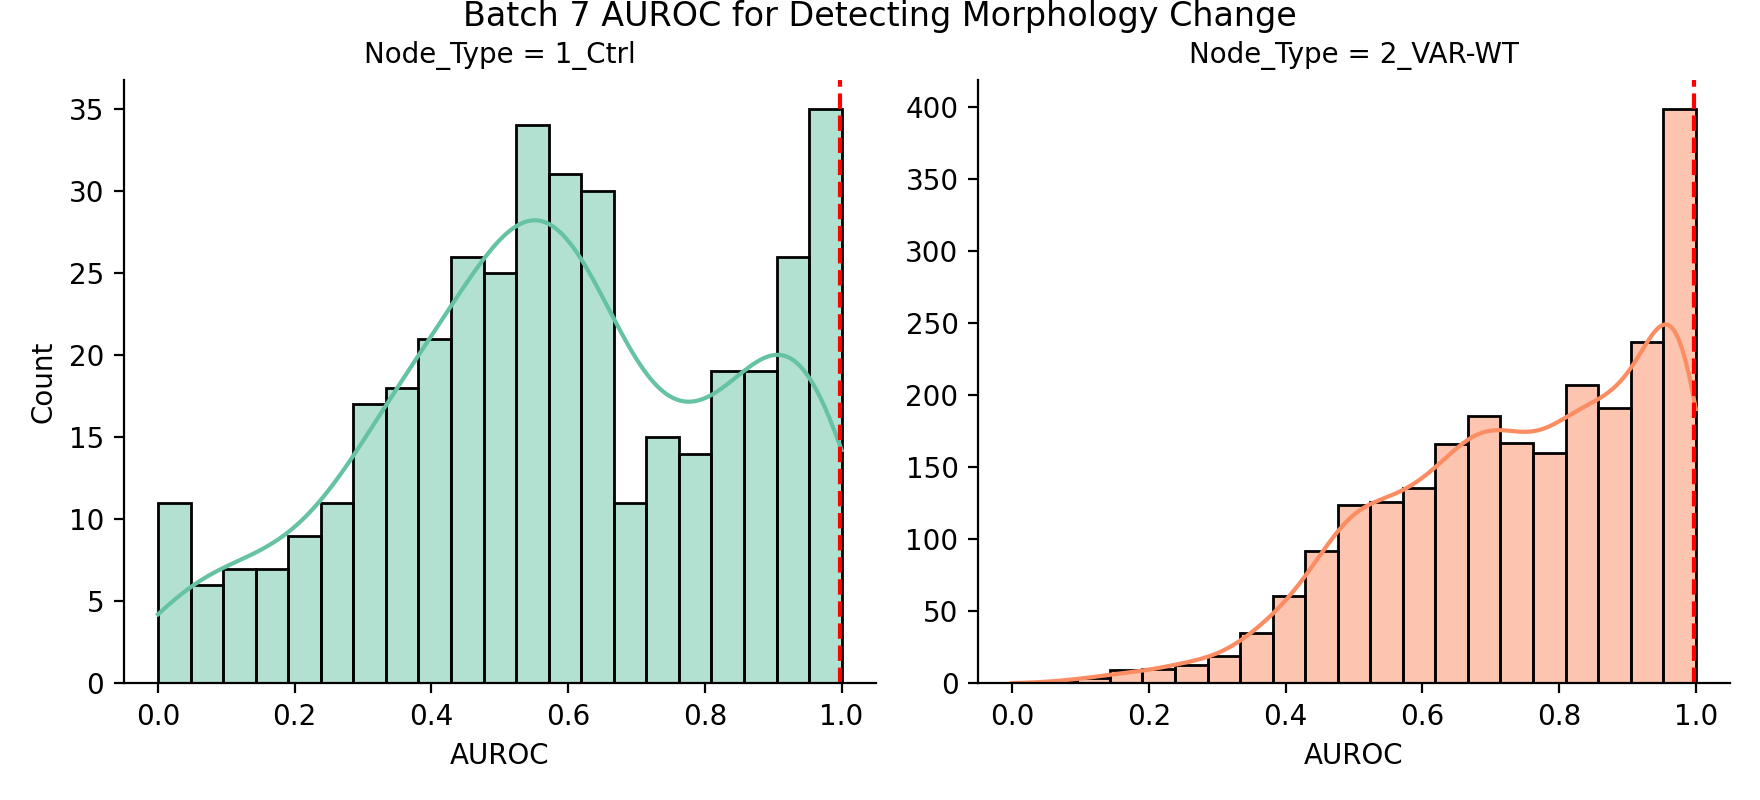

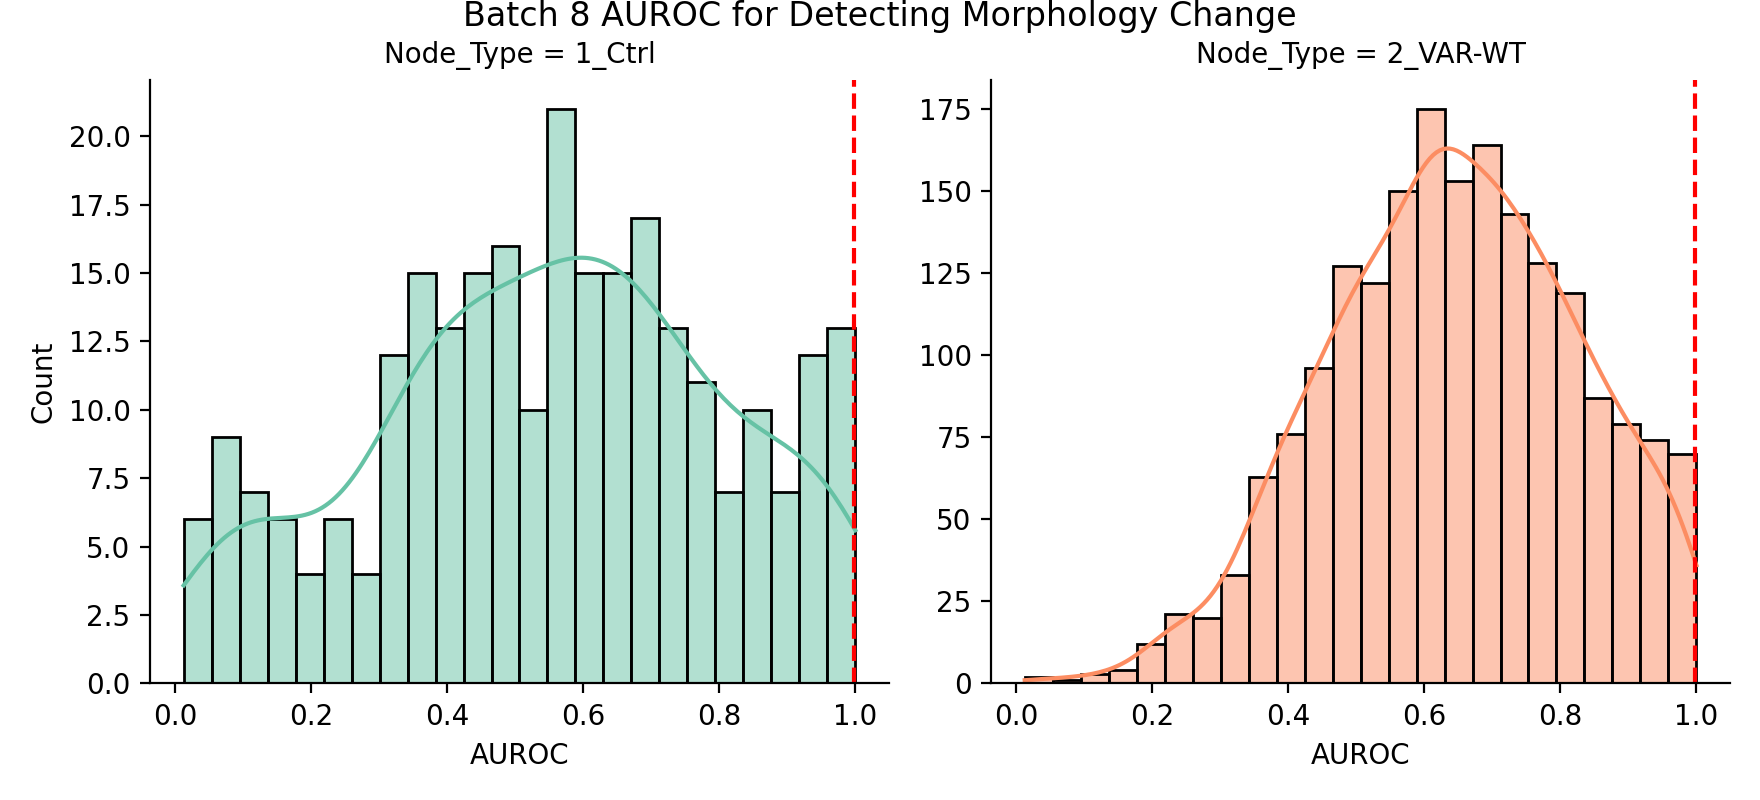

In [151]:
perc_99 = metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "morphology").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B7_met_thres"].filter(pl.col("Classifier_type") == "morphology"), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
# plt.show()

g.fig.suptitle("Batch 7 AUROC for Detecting Morphology Change", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

perc_99 = metric_df_dict["B8_met_thres"].filter(pl.col("Classifier_type") == "morphology").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B8_met_thres"].filter(pl.col("Classifier_type") == "morphology"), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')

g.fig.suptitle("Batch 8 AUROC for Detecting Morphology Change", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

In [34]:
metrics_files = [
    "../outputs/analyses/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect/metrics_summary.csv",
    "../outputs/analyses/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect/metrics_summary.csv"
]

metric_sum_df_dict = {}

for metric_file in metrics_files:
    metric_sum_df = pl.read_csv(metric_file)

    # Assuming you have a Polars DataFrame named df and you want to rank the values in the 'column_name' column
    metric_sum_df = metric_sum_df.with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    )

    print(metric_sum_df.filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))))
    print(metric_sum_df.filter((pl.col("Classifier_type") == "morphology")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))))

    metric_sum_df_dict[metric_file.split("/")[-3]] = metric_sum_df

shape: (289, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Classi ┆ allele ┆ Allele ┆ Batch ┆ AUROC ┆ AUROC ┆ train ┆ tests ┆ train ┆ tests ┆ Train ┆ AUROC │
│ fier_t ┆ _0     ┆ _set   ┆ ---   ┆ _thre ┆ _mean ┆ size_ ┆ ize_0 ┆ size_ ┆ ize_1 ┆ ing_i ┆ _rank │
│ ype    ┆ ---    ┆ ---    ┆ str   ┆ sh    ┆ ---   ┆ 0_mea ┆ _mean ┆ 1_mea ┆ _mean ┆ mbala ┆ ---   │
│ ---    ┆ str    ┆ str    ┆       ┆ ---   ┆ f64   ┆ n     ┆ ---   ┆ n     ┆ ---   ┆ nce_m ┆ u32   │
│ str    ┆        ┆        ┆       ┆ f64   ┆       ┆ ---   ┆ f64   ┆ ---   ┆ f64   ┆ ean   ┆       │
│        ┆        ┆        ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆ ---   ┆       │
│        ┆        ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ f64   ┆       │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ locali ┆ PYGL_A ┆ A1P3   ┆ B7    ┆ 0.714 ┆ 0.836 ┆ 614.2 ┆ 204.7 ┆ 814.5

Spearman's correlation: 0.32318537090470617


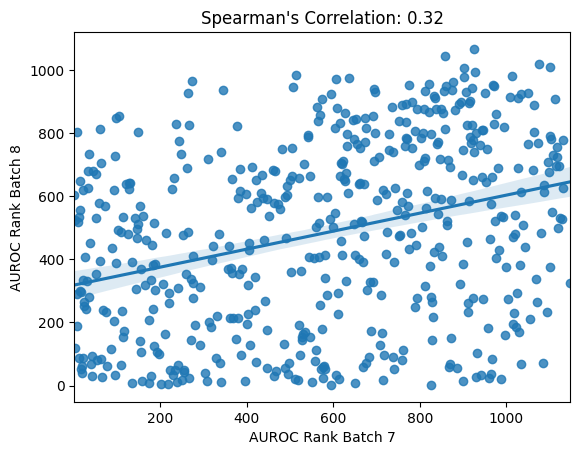

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Select the columns "allele_0" and "AUROC_rank" from both dataframes
set1_ranks = metric_sum_df_dict["2024_01_23_Batch_7"].filter((pl.col("Classifier_type") == "morphology")).select(["allele_0", "AUROC_rank"])
set2_ranks = metric_sum_df_dict["2024_02_06_Batch_8"].filter((pl.col("Classifier_type") == "morphology")).select(["allele_0", "AUROC_rank"])

# Join the dataframes on the "allele_0" column
joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch8")

# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch8"])
print(f"Spearman's correlation: {spearman_corr}")

# Plot the correlation using a regression plot
sns.regplot(x="AUROC_rank", y="AUROC_rank_batch8", data=joined_ranks.to_pandas())
plt.title(f"Spearman's Correlation: {spearman_corr:.2f}")
plt.xlabel("AUROC Rank Batch 7")
plt.ylabel("AUROC Rank Batch 8")
plt.show()

In [40]:
joined_ranks

allele_0,AUROC_rank,AUROC_rank_batch8
str,u32,u32
"""NEXN_Tyr544Cys""",406,431
"""DES_Leu274Pro""",922,653
"""PMP22_Arg157Trp""",741,51
"""POMT1_Ser515Arg""",271,143
"""MVK_His20Gln""",131,642
"""ALAS2_Ala135Thr""",244,774
"""MVK_Val250Ile""",775,952
"""NEUROG3_Gly167Arg""",329,88
"""HPRT1_Asp177Tyr""",558,77


Spearman's correlation: 0.8535362803537261


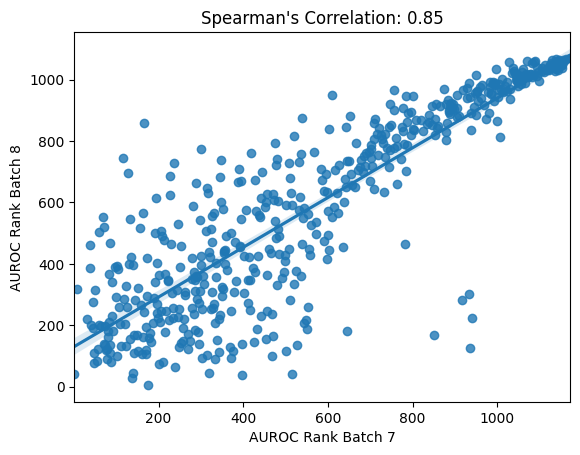

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Select the columns "allele_0" and "AUROC_rank" from both dataframes
set1_ranks = metric_sum_df_dict["2024_01_23_Batch_7"].filter((pl.col("Classifier_type") == "localization")).select(["allele_0", "AUROC_rank"])
set2_ranks = metric_sum_df_dict["2024_02_06_Batch_8"].filter((pl.col("Classifier_type") == "localization")).select(["allele_0", "AUROC_rank"])

# Join the dataframes on the "allele_0" column
joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch8")

# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch8"])
print(f"Spearman's correlation: {spearman_corr}")

# Plot the correlation using a regression plot
sns.regplot(x="AUROC_rank", y="AUROC_rank_batch8", data=joined_ranks.to_pandas())
plt.title(f"Spearman's Correlation: {spearman_corr:.2f}")
plt.xlabel("AUROC Rank Batch 7")
plt.ylabel("AUROC Rank Batch 8")
plt.show()

In [23]:
set1 = metric_sum_df_dict["2024_01_23_Batch_7"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))
set2 = metric_sum_df_dict["2024_02_06_Batch_8"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))

In [32]:
len(set(set1.to_series().to_numpy()).intersection(set(set2.to_series().to_numpy()))) / 969

0.12693498452012383